In [1]:
import numpy as np
import veloxchem as vlx

In [2]:
ethylene_xyz = """
6

C        0.67759997    0.00000000   0.00000000
C       -0.67759997    0.00000000   0.00000000
H        1.21655197    0.92414474   0.00000000
H        1.21655197   -0.92414474   0.00000000
H       -1.21655197   -0.92414474   0.00000000
H       -1.21655197    0.92414474   0.00000000
"""

In [3]:
molecule = vlx.Molecule.read_xyz_string(ethylene_xyz)
basis = vlx.MolecularBasis.read(molecule, "def2-svp", ostream=None)

nocc = molecule.number_of_alpha_electrons()
norb = basis.get_dimension_of_basis()
nvirt = norb - nocc

homo = nocc - 1  # Python indexing of orbitals

In [4]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_results = scf_drv.compute(molecule, basis)

In [5]:
S = scf_results["S"]
C = scf_results["C_alpha"]

In [6]:
lrf_drv = vlx.LinearResponseSolver()
lrf_drv.ostream.mute()

lrf_drv.frequencies = [0.0]
lrf_drv.b_components = ["x"]
lrf_results = lrf_drv.compute(molecule, basis, scf_results)

In [7]:
Z = (
    -0.5
    * (
        lrf_results["solutions"][("x", 0.0)].get_full_vector(0)
        + lrf_results["solutions"][("x", 0.0)].get_full_vector(1)
    )
    * np.sqrt(2)
)

# parameter for the pi-pi* excitation
# sign is arbitrary and is therefore here set
z = abs(Z[(nocc - 1) * nvirt]) 

In [8]:
field_strengths = np.linspace(-0.1, 0.1, 5)

S_field = []

for F in field_strengths:
    scf_drv.electric_field = [F, 0.0, 0.0]  # apply an electric field in the x-direction
    scf_results = scf_drv.compute(molecule, basis)
    C_field = scf_results["C_alpha"]

    S_field.append(
        np.sign(F) * abs(np.einsum("a, b, ab ->", C[:, homo + 1], C_field[:, homo], S))
    )  # the arbitrary sign is set

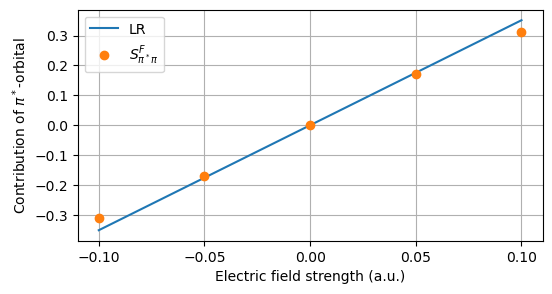

In [9]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(6, 3))

plt.plot(field_strengths, z * field_strengths, label="LR")
plt.plot(field_strengths, S_field, "o", label=r"$S_{{\pi^*}\pi}^F$")

plt.setp(plt.gca(), xticks=field_strengths)

plt.legend(frameon=True)
plt.ylabel(r"Contribution of $\pi^*$-orbital")
plt.xlabel("Electric field strength (a.u.)")

plt.grid(True)

plt.show()